In [3]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=0cd1e862cc398e9fda6cd91cc18bf915a2ea88ac9adf1d571fbc392dd615cb20
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [120]:
import pyspark
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [121]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import avg, col, concat, count, desc, asc, explode, lit, split, stddev, udf, isnan, when, rank, from_unixtime

In [122]:
from pyspark.sql import SparkSession

In [123]:
spark = SparkSession.builder.appName(
  "pandas to spark").getOrCreate()

In [125]:
df_spark = spark.read.option('header', 'true').csv("/content/transactions-20230501_141813-40.csv")

In [126]:
df_spark

DataFrame[_c0: string, 1: string, Txn Hash: string, Method: string, Block: string, 2: string, Age: string, 3: string, From: string, 4: string, To: string, Value: string, Txn Fee: string, 5: string]

In [127]:
df_spark.show()

+---+----+--------------------+-------------------+--------+----+---------+----+--------------------+----+--------------------+---------------+----------+----+
|_c0|   1|            Txn Hash|             Method|   Block|   2|      Age|   3|                From|   4|                  To|          Value|   Txn Fee|   5|
+---+----+--------------------+-------------------+--------+----+---------+----+--------------------+----+--------------------+---------------+----------+----+
|  0|null|0x5a5404f46230fe1...|Append Sequencer...|17164854|null|1 min ago|null| Optimism: Sequencer|null|Optimism: Canonic...|          0 ETH|0.01305627|null|
|  1|null|0xcd1d6b6ce3648a2...|            Unoswap|17164854|null|1 min ago|null| 0x0b1dD8...B82d9bC7|null|1inch v5: Aggrega...|          0 ETH|0.00549903|null|
|  2|null|0xe2a1a884ebe841c...|            Approve|17164854|null|1 min ago|null| 0x9Ab8F9...8Ab74CCF|null| 0x0575A5...2FaA3a79|          0 ETH|0.00190457|null|
|  3|null|0x223635c5cde550d...|         

In [128]:
df_spark.columns

['_c0',
 '1',
 'Txn Hash',
 'Method',
 'Block',
 '2',
 'Age',
 '3',
 'From',
 '4',
 'To',
 'Value',
 'Txn Fee',
 '5']

In [129]:
columns_to_drop = ['1', '2','3','4','5']
df = df_spark.drop(*columns_to_drop)

In [130]:
df.show()

+---+--------------------+-------------------+--------+---------+--------------------+--------------------+---------------+----------+
|_c0|            Txn Hash|             Method|   Block|      Age|                From|                  To|          Value|   Txn Fee|
+---+--------------------+-------------------+--------+---------+--------------------+--------------------+---------------+----------+
|  0|0x5a5404f46230fe1...|Append Sequencer...|17164854|1 min ago| Optimism: Sequencer|Optimism: Canonic...|          0 ETH|0.01305627|
|  1|0xcd1d6b6ce3648a2...|            Unoswap|17164854|1 min ago| 0x0b1dD8...B82d9bC7|1inch v5: Aggrega...|          0 ETH|0.00549903|
|  2|0xe2a1a884ebe841c...|            Approve|17164854|1 min ago| 0x9Ab8F9...8Ab74CCF| 0x0575A5...2FaA3a79|          0 ETH|0.00190457|
|  3|0x223635c5cde550d...|            Execute|17164854|1 min ago| 0x456982...5C4bBBA6|Uniswap: Universa...|       0.08 ETH|0.00702675|
|  4|0x0e43bd50cc1c128...|Append State Bat...|17164854|

In [131]:
df.count()

1000

In [132]:
df.describe().show()

+-------+-----------------+--------------------+-------------------+-----------------+----------+----------+--------------------+--------+--------------------+
|summary|              _c0|            Txn Hash|             Method|            Block|       Age|      From|                  To|   Value|             Txn Fee|
+-------+-----------------+--------------------+-------------------+-----------------+----------+----------+--------------------+--------+--------------------+
|  count|             1000|                1000|               1000|             1000|      1000|      1000|                1000|    1000|                1000|
|   mean|            499.5|                null|               null|   1.7164865397E7|      null|      null|                null|    null|0.005411258339999998|
| stddev|288.8194360957494|                null|               null|6.725371493452646|      null|      null|                null|    null|0.010797917322240957|
|    min|                0|0x0001bcc8cee

In [133]:
def count_missing(df, col):
    """
    A helper function which count how many missing values in a colum of the dataset.
    
    This function is useful because the data can be either three cases below:
    
    1. NaN
    2. Null
    3. "" (empty string)
    """
    return df.filter((isnan(df[col])) | (df[col].isNull()) | (df[col] == "") | (df[col] == "null")).count()

In [134]:
print("[missing values]\n")
for col in df.columns:
    missing_count = count_missing(df, col)
    if missing_count > 0:
        print("{}: {}".format(col, missing_count))

[missing values]



In [135]:
df.schema

StructType([StructField('_c0', StringType(), True), StructField('Txn Hash', StringType(), True), StructField('Method', StringType(), True), StructField('Block', StringType(), True), StructField('Age', StringType(), True), StructField('From', StringType(), True), StructField('To', StringType(), True), StructField('Value', StringType(), True), StructField('Txn Fee', StringType(), True)])

In [136]:
from pyspark.sql.types import IntegerType, LongType, DoubleType
df = df.withColumn("Txn Fee", df["Txn Fee"].cast(DoubleType()))

In [137]:
df.schema

StructType([StructField('_c0', StringType(), True), StructField('Txn Hash', StringType(), True), StructField('Method', StringType(), True), StructField('Block', StringType(), True), StructField('Age', StringType(), True), StructField('From', StringType(), True), StructField('To', StringType(), True), StructField('Value', StringType(), True), StructField('Txn Fee', DoubleType(), True)])

In [138]:
df.show()

+---+--------------------+-------------------+--------+---------+--------------------+--------------------+---------------+----------+
|_c0|            Txn Hash|             Method|   Block|      Age|                From|                  To|          Value|   Txn Fee|
+---+--------------------+-------------------+--------+---------+--------------------+--------------------+---------------+----------+
|  0|0x5a5404f46230fe1...|Append Sequencer...|17164854|1 min ago| Optimism: Sequencer|Optimism: Canonic...|          0 ETH|0.01305627|
|  1|0xcd1d6b6ce3648a2...|            Unoswap|17164854|1 min ago| 0x0b1dD8...B82d9bC7|1inch v5: Aggrega...|          0 ETH|0.00549903|
|  2|0xe2a1a884ebe841c...|            Approve|17164854|1 min ago| 0x9Ab8F9...8Ab74CCF| 0x0575A5...2FaA3a79|          0 ETH|0.00190457|
|  3|0x223635c5cde550d...|            Execute|17164854|1 min ago| 0x456982...5C4bBBA6|Uniswap: Universa...|       0.08 ETH|0.00702675|
|  4|0x0e43bd50cc1c128...|Append State Bat...|17164854|

In [139]:
split_col = pyspark.sql.functions.split(df['Value'], ' ')
df = df.withColumn('Val', split_col.getItem(0))
df = df.withColumn('Type', split_col.getItem(1))

In [140]:
df.show()

+---+--------------------+-------------------+--------+---------+--------------------+--------------------+---------------+----------+-----------+----+
|_c0|            Txn Hash|             Method|   Block|      Age|                From|                  To|          Value|   Txn Fee|        Val|Type|
+---+--------------------+-------------------+--------+---------+--------------------+--------------------+---------------+----------+-----------+----+
|  0|0x5a5404f46230fe1...|Append Sequencer...|17164854|1 min ago| Optimism: Sequencer|Optimism: Canonic...|          0 ETH|0.01305627|          0| ETH|
|  1|0xcd1d6b6ce3648a2...|            Unoswap|17164854|1 min ago| 0x0b1dD8...B82d9bC7|1inch v5: Aggrega...|          0 ETH|0.00549903|          0| ETH|
|  2|0xe2a1a884ebe841c...|            Approve|17164854|1 min ago| 0x9Ab8F9...8Ab74CCF| 0x0575A5...2FaA3a79|          0 ETH|0.00190457|          0| ETH|
|  3|0x223635c5cde550d...|            Execute|17164854|1 min ago| 0x456982...5C4bBBA6|Un

In [141]:
df = df.withColumn("Val", df["Val"].cast(DoubleType()))

In [142]:
num_cols = []
cat_cols = []

for s in df.schema:
    data_type = str(s.dataType)
    if data_type == "StringType()":
        cat_cols.append(s.name)
    
    if data_type == "LongType()" or data_type == "DoubleType()":
        num_cols.append(s.name)

In [143]:
num_cols

['Txn Fee', 'Val']

In [144]:
cat_cols

['_c0', 'Txn Hash', 'Method', 'Block', 'Age', 'From', 'To', 'Value', 'Type']

In [145]:
cols = ['_c0','Value']
df1 = df.drop(*cols)

In [146]:
df1.show()

+--------------------+-------------------+--------+---------+--------------------+--------------------+----------+-----------+----+
|            Txn Hash|             Method|   Block|      Age|                From|                  To|   Txn Fee|        Val|Type|
+--------------------+-------------------+--------+---------+--------------------+--------------------+----------+-----------+----+
|0x5a5404f46230fe1...|Append Sequencer...|17164854|1 min ago| Optimism: Sequencer|Optimism: Canonic...|0.01305627|        0.0| ETH|
|0xcd1d6b6ce3648a2...|            Unoswap|17164854|1 min ago| 0x0b1dD8...B82d9bC7|1inch v5: Aggrega...|0.00549903|        0.0| ETH|
|0xe2a1a884ebe841c...|            Approve|17164854|1 min ago| 0x9Ab8F9...8Ab74CCF| 0x0575A5...2FaA3a79|0.00190457|        0.0| ETH|
|0x223635c5cde550d...|            Execute|17164854|1 min ago| 0x456982...5C4bBBA6|Uniswap: Universa...|0.00702675|       0.08| ETH|
|0x0e43bd50cc1c128...|Append State Bat...|17164854|1 min ago|Optimism: State

### Top 5 Methods of Transactions

In [147]:
l = df1.groupBy('Method').count()
l1 = l.sort('count', ascending=False).limit(8)

In [148]:
l1 = l1.toPandas()

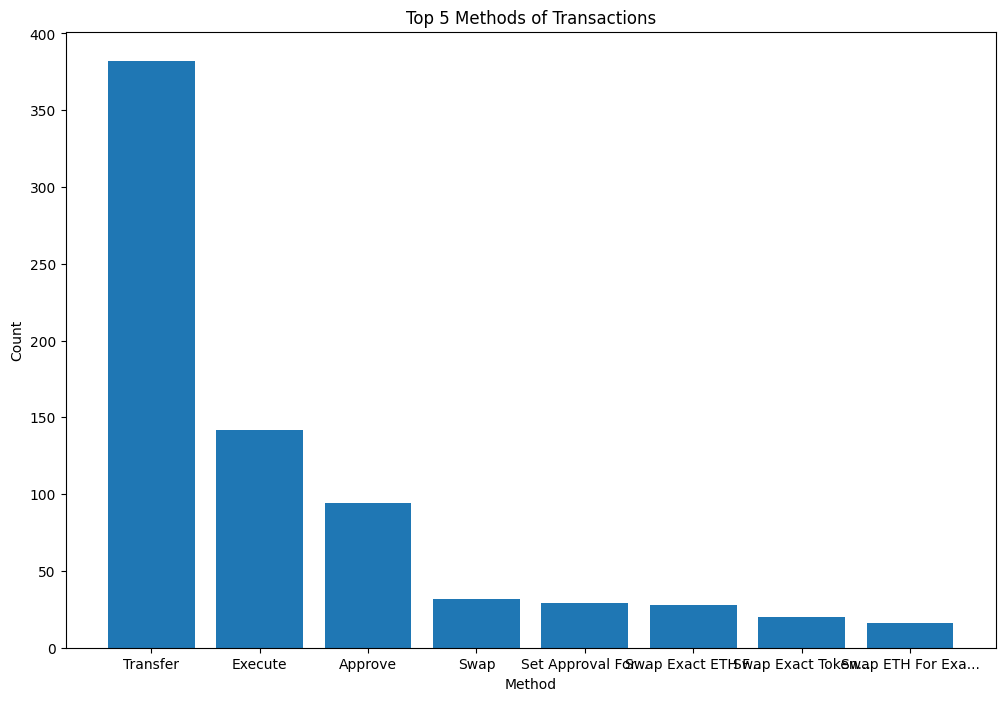

In [149]:
plt.figure(figsize=(12,8))
plt.bar(l1['Method'],l1['count'])
plt.xlabel('Method')
plt.ylabel('Count')
plt.title('Top 5 Methods of Transactions')
plt.show()

### Methods with Highest Etherium Transaction Value

In [150]:
df_cat_val = df1.groupby("Method").agg({'Val': "sum"})

In [151]:
df_cat_val.count()

155

In [152]:
df_cat_val.show()

+-------------------+--------------------+
|             Method|            sum(Val)|
+-------------------+--------------------+
|             Cancel|                 0.0|
|       Admin Cancel|                 0.0|
|   Mooo Z1089603480|                 0.0|
|         0x3c2f385e|                 0.0|
|      Commit Blocks|                 0.0|
|    Mint Allow List|                 0.0|
|      Claim Rewards|                 0.0|
|     Set Sell Taxes|                 0.0|
|           Purchase|0.004885000000000...|
|         0x3111c54f|         0.252956998|
|      Submit Prices|                 0.0|
|         0x60a06040|                 0.0|
|Emergency Withdr...|                 0.0|
|Safe Transfer Fr...|                 0.0|
|Liquidated Asset...|                 0.0|
|        Flush ERC20|                 0.0|
|         0xf867beb4|                 0.0|
|            Deposit|   65.20086767299999|
|   Any Swap In Auto|                 0.0|
|         0x020965d0|                45.0|
+----------

In [153]:
method_high_transaction = df_cat_val.sort('sum(Val)', ascending=False).limit(5)

In [154]:
method_high_transaction = method_high_transaction.toPandas()

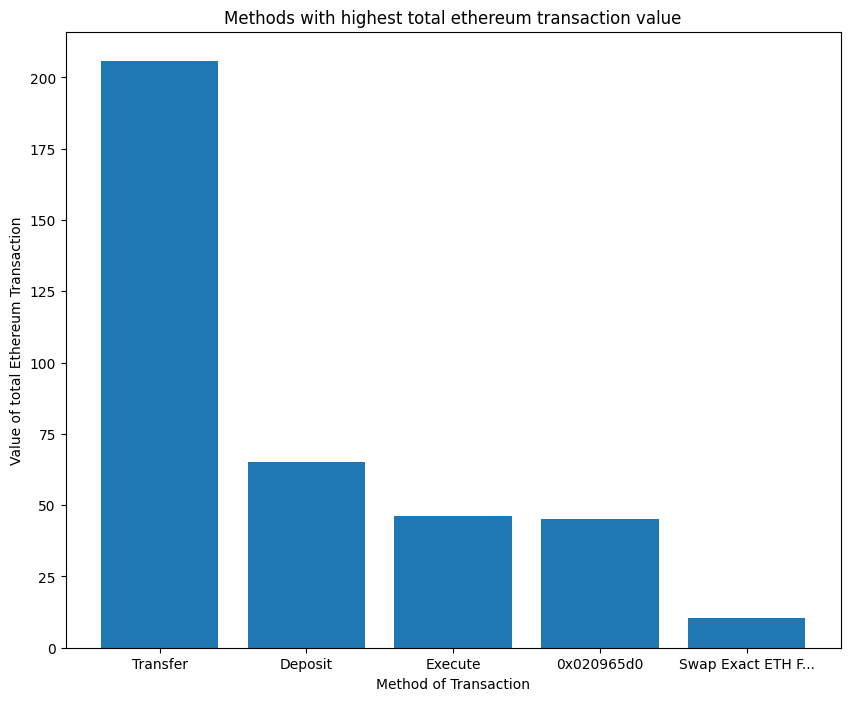

In [155]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.bar(method_high_transaction['Method'],method_high_transaction['sum(Val)'])
plt.xlabel('Method of Transaction')
plt.ylabel('Value of total Ethereum Transaction')
plt.title('Methods with highest total ethereum transaction value')
plt.show()

In [156]:
df1.select("Method", "Val", "Txn Fee").show(5)

+-------------------+----+----------+
|             Method| Val|   Txn Fee|
+-------------------+----+----------+
|Append Sequencer...| 0.0|0.01305627|
|            Unoswap| 0.0|0.00549903|
|            Approve| 0.0|0.00190457|
|            Execute|0.08|0.00702675|
|Append State Bat...| 0.0| 0.0537479|
+-------------------+----+----------+
only showing top 5 rows



### Analysing Top Etherium Transactions

In [157]:
top_5_eth_transaction = df1.sort('Val', ascending=False).limit(5)

In [158]:
top_5_eth_transaction.show()

+--------------------+----------+--------+----------+-------------------+--------------------+----------+--------+----+
|            Txn Hash|    Method|   Block|       Age|               From|                  To|   Txn Fee|     Val|Type|
+--------------------+----------+--------+----------+-------------------+--------------------+----------+--------+----+
|0x1842d45a459e78b...|   Deposit|17164858| 1 min ago|0xd65a7B...066F4f7B|Beacon Deposit Co...|0.00206126|    32.0| ETH|
|0x0491692f152d35e...|   Deposit|17164863| 1 min ago|0xd65a7B...066F4f7B|Beacon Deposit Co...|0.00212766|    32.0| ETH|
|0x1b9ea6ba03b4892...|  Transfer|17164864| 1 min ago|          KuCoin 10| 0x1f6805...33F0e4A1| 9.0283E-4|  29.995| ETH|
|0x11fa57a047393ab...|  Transfer|17164863| 1 min ago|         Binance 20| 0x2BbB48...540f66b0| 8.6124E-4|19.99818| ETH|
|0xb731ed10ea38dc4...|0x020965d0|17164869|2 mins ago|0xad67D3...6b9E4a0f|   Seawise: Resolver| 0.0084735|    19.0| wei|
+--------------------+----------+-------

* **This is the transaction information of the top 5 ethereum value transactions**

### Analysing transactions with highest and lowest gas fees

In [159]:
high_5_gas_fee = df1.sort('Txn Fee', ascending=False).limit(5)

In [160]:
high_5_gas_fee.show()

+--------------------+-------------------+--------+----------+-------------------+--------------------+----------+---+----+
|            Txn Hash|             Method|   Block|       Age|               From|                  To|   Txn Fee|Val|Type|
+--------------------+-------------------+--------+----------+-------------------+--------------------+----------+---+----+
|0x88d8acff1b0dbbb...|         0x42753707|17164866|2 mins ago|jaredfromsubway.eth|MEV Bot: 0x6b7...A80|0.14597547|0.0| ETH|
|0xdc1e97bd69628d2...|Add Liquidity ET...|17164870|2 mins ago|0x3Ec88f...bD29B6ff|Uniswap V2: Router 2|0.11341322|2.5| ETH|
|0x50dc41352dc2a3b...|         0x406b395d|17164864| 1 min ago|jaredfromsubway.eth|MEV Bot: 0x6b7...A80|0.10948562|0.0| ETH|
|0x0a1a7df7d358834...|         0x60a06040|17164863| 1 min ago|0xf87BC5...907a843D|   Contract Creation|0.08414218|0.0| ETH|
|0x4d66318bbe63ae2...|Swap Exact ETH F...|17164864| 1 min ago|0xB42F65...4f691bE8|Uniswap V2: Router 2|0.08135493|0.2| ETH|
+-------

In [161]:
low_5_gas_fee = df1.sort('Txn Fee', ascending=True).limit(5)

In [162]:
low_5_gas_fee.show()

+--------------------+--------+--------+----------+-------------------+-------------------+---------+-----------+----+
|            Txn Hash|  Method|   Block|       Age|               From|                 To|  Txn Fee|        Val|Type|
+--------------------+--------+--------+----------+-------------------+-------------------+---------+-----------+----+
|0x7c7bd5280debd22...|Transfer|17164863|2 mins ago|0x0A772A...aC3518ca|0xC3Af4f...a3e30B19|8.2134E-4|        0.3| ETH|
|0xd3c63a253f64f45...|Transfer|17164875|2 mins ago|0x79BC8d...847A6BfC|0xA94983...24939F16|8.2507E-4|0.008201192| ETH|
|0xbaf2324ec447918...|Transfer|17164875|2 mins ago|0x37C724...F4BbB354|0xfb148f...27a12B77|8.2507E-4|     0.0054| ETH|
|0x79ccc8836841d5f...|Transfer|17164875|2 mins ago|          3nety.eth|   complexcrypto1.x|8.2507E-4|    0.08167| ETH|
|0xa2bf9273b280cd3...|Transfer|17164876|2 mins ago|         emxart.eth|0x4eaf55...4f5c0714|8.3255E-4|    0.01129| ETH|
+--------------------+--------+--------+--------

### Comparison b/w gas prices and transaction timings

In [163]:
split_col = pyspark.sql.functions.split(df1['Age'], ' ')
df1 = df1.withColumn('Time', split_col.getItem(0))
# df = df1.withColumn('Unit', split_col.getItem(1))

In [164]:
df1.show()

+--------------------+-------------------+--------+---------+--------------------+--------------------+----------+-----------+----+----+
|            Txn Hash|             Method|   Block|      Age|                From|                  To|   Txn Fee|        Val|Type|Time|
+--------------------+-------------------+--------+---------+--------------------+--------------------+----------+-----------+----+----+
|0x5a5404f46230fe1...|Append Sequencer...|17164854|1 min ago| Optimism: Sequencer|Optimism: Canonic...|0.01305627|        0.0| ETH|   1|
|0xcd1d6b6ce3648a2...|            Unoswap|17164854|1 min ago| 0x0b1dD8...B82d9bC7|1inch v5: Aggrega...|0.00549903|        0.0| ETH|   1|
|0xe2a1a884ebe841c...|            Approve|17164854|1 min ago| 0x9Ab8F9...8Ab74CCF| 0x0575A5...2FaA3a79|0.00190457|        0.0| ETH|   1|
|0x223635c5cde550d...|            Execute|17164854|1 min ago| 0x456982...5C4bBBA6|Uniswap: Universa...|0.00702675|       0.08| ETH|   1|
|0x0e43bd50cc1c128...|Append State Bat...

In [165]:
comp = df1.select("Txn Fee","Time")

In [166]:
comp = comp.toPandas()

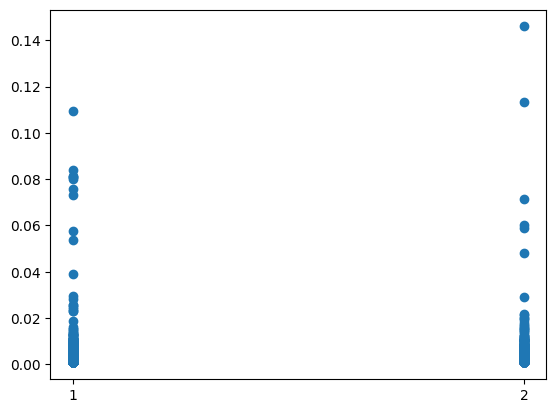

In [167]:
plt.scatter(comp['Time'],comp['Txn Fee'])
plt.show()